In [1]:
pip install iisignature

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iisignature: filename=iisignature-0.24-cp311-cp311-linux_x86_64.whl size=3246117 sha256=e78946d7667bb5a1499568b6cdef0a60a66b75263a68ae1a8caf8950da7917cd
  Stored in directory: /root/.cache/pip/wheels/1c/f4/57/0b4d3787a07f20a3cd1a91835d6247f55ef899345267bcd6df
Successfully built iisignature


In [3]:
import iisignature
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def generate_words(alphabet, max_order, include_empty=True):
    """
    Génère les mots de l'alphabet donné jusqu'au max_order.

    Paramètres :
      - alphabet : liste ou tuple des symboles (par exemple [1, 2])
      - max_order : l'ordre maximum des mots (exclut le mot vide si include_empty=False)
      - include_empty : inclure le mot vide () au début (True par défaut)

    Retourne :
      - une liste de tuples représentant les mots dans l'ordre gradué lexicographique.
    """
    words = []
    if include_empty:
        words.append(())
    for order in range(1, max_order + 1):
        # itertools.product génère tous les produits cartésiens de longueur 'order'
        for word in itertools.product(alphabet, repeat=order):
            words.append(word)
    return words

In [5]:
def exp_shuffle(letter  , scalar , degree_max,words) :
  d={}
  for i in range(len(words)):
    d[words[i]]=0
  for i in range (degree_max) :
    d[(letter,)*i] = scalar **i
  return d

In [6]:
def concat(a , b ,words):
  result = {}
  for i in a.keys() :
    result[i]=0
  for item1 in a.keys() :
    for item2 in b.keys() :
      if item1+item2 in words :
        result[item1+item2]= result[item1+item2] + a[item1] * b[item2]
  return result

In [7]:
def add(a,b) :
  result = {}
  for key in a.keys() :
    result[key]=0
  for item in a.keys() :
    result[item] = a[item] + b[item]
  return result

In [8]:
def create_empty(d,m) :
  alphabet = [i for i in range(1,d+1)]
  words = generate_words(alphabet, m)
  empty_dic={}
  for i in range(len(words)):
    empty_dic[words[i]]=0
  return empty_dic

In [9]:
def l_hat_at_t(t,d,m,words):
  l_hat = create_empty(d,m)
  l_hat[()] = theta + np.exp(-kappa*t) * (x0-theta)
  word_2 =create_empty(d,m)
  word_2[(2,)] = eta * np.exp(-kappa * t)
  exp_shuffle_word = exp_shuffle(1,kappa,m,words)
  c=concat(exp_shuffle_word,word_2 , words)
  l_hat = add(l_hat, c)
  return l_hat


In [10]:
# Parameters
x0 = 0.2
kappa = 4
theta = 0.25
eta = 2
T = 1
dt = 0.005

# Number of time steps and time grid
N = int(T / dt)
t = np.linspace(0, T, N + 1)

# Number of Monte Carlo simulations
N_sim = 1000

In [11]:
# Each row corresponds to one simulation, each column to one time point
X_paths = np.zeros((N_sim, N + 1))
# Optionally, store the Brownian increments (each row for one simulation)
dW_matrix = np.zeros((N_sim, N))

# Monte Carlo simulation loop
for i in range(N_sim):
    # Generate Brownian increments for one simulation
    dW = np.sqrt(dt) * np.random.randn(N)
    dW_matrix[i, :] = dW

    # Initialize the OU process path for this simulation
    X = np.zeros(N + 1)
    X[0] = x0

    # Euler–Maruyama scheme for the OU process
    for j in range(1, N + 1):
        X[j] = X[j - 1] + kappa * (theta - X[j - 1]) * dt + eta * dW[j - 1]

    # Save the full path into the X_paths array
    X_paths[i, :] = X


# Optionally, calculate the mean path over time (averaging over simulations)
mean_path = np.mean(X_paths, axis=0)

dW=np.mean(dW_matrix,axis=0)
W = np.zeros(N + 1)
W[1:] = np.cumsum(dW)
path = np.column_stack((t, W))

In [11]:
def plot_ou(max_order,d) :
  plt.figure(figsize=(10, 6))
  plt.plot(t,mean_path,label="MC PATH")
  alphabet = [i for i in range(1,d+1)]
  for m in range(2,max_order+1) :
    words = generate_words(alphabet, m)
    l = l_hat_at_t(t,d,m,words)
    OU= np.zeros_like(t)
    OU[0]=x0
    signature_length = iisignature.siglength(d,m) + 1
    for i in range(1,N+1) :
      signature = iisignature.sig(path[:i,:], m)
      dic=create_empty(d,m)
      dic[()]=1
      for j in range(1,signature_length) :
        dic[words[j]]=signature[j-1]
      S=0
      l=l_hat_at_t(t[i],d,m,words)
      for key in dic.keys() :
        S=S+l[key]*dic[key]

      OU[i]=S
    plt.plot(t,OU,label = str(m))
  plt.legend()
  plt.show()


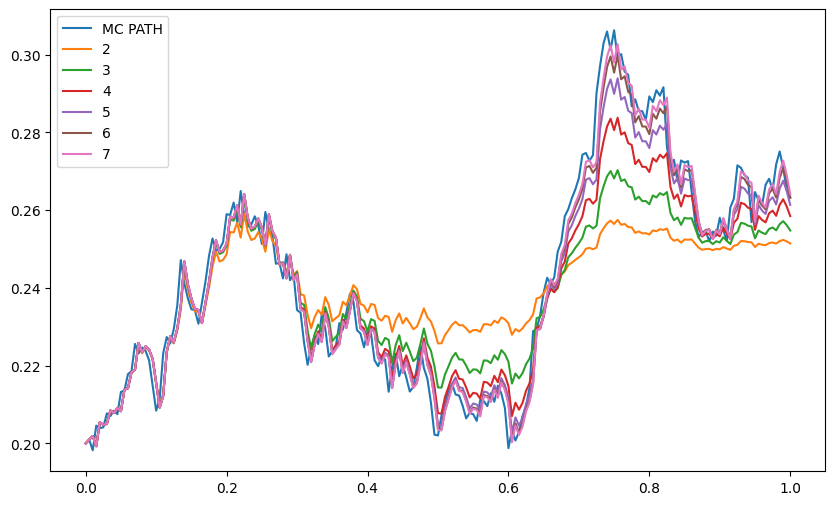

In [ ]:
plot_ou(7,2)

Fourier

In [12]:
def shuffle_words(w1, w2):
    """
    Recursively compute the shuffle product of two words (tuples).
    Returns a dictionary mapping resulting words to combinatorial coefficients.
    """
    if not w1:
        return {w2: 1}
    if not w2:
        return {w1: 1}

    head1, tail1 = w1[0], w1[1:]
    head2, tail2 = w2[0], w2[1:]

    res = {}
    # Prepend head1 and shuffle the rest.
    for w, c in shuffle_words(tail1, w2).items():
        new_word = (head1,) + w
        res[new_word] = res.get(new_word, 0) + c
    # Prepend head2 and shuffle the rest.
    for w, c in shuffle_words(w1, tail2).items():
        new_word = (head2,) + w
        res[new_word] = res.get(new_word, 0) + c
    return res

In [13]:
shuffle_words((1,2),(1,1))

{(1, 2, 1, 1): 1, (1, 1, 2, 1): 2, (1, 1, 1, 2): 3}

In [14]:
def shuffle_presentation(a , b, d , m) :
  result= create_empty(d,m)
  for key_a in a.keys() :
    for key_b in b.keys() :
      if a[key_a] != 0 and b[key_b] != 0 :
        suffle = shuffle_words(key_a,key_b)
        for key_suffle in suffle.keys() :
          if key_suffle in result.keys() :
            result[key_suffle] += a[key_a] * b[key_b] * suffle[key_suffle]
  return result

In [15]:
d=2
m=2
alphabet = [i for i in range(1,d+1)]
words = generate_words(alphabet, m)
a=create_empty(d,m)
b=create_empty(d,m)
a[()]= 1
a[(1,)] = 1
a[(2,1)] = 1
shuffle_presentation(a,a,d,2*m)

{(): 1,
 (1,): 2,
 (2,): 0,
 (1, 1): 2,
 (1, 2): 0,
 (2, 1): 2,
 (2, 2): 0,
 (1, 1, 1): 0,
 (1, 1, 2): 0,
 (1, 2, 1): 2,
 (1, 2, 2): 0,
 (2, 1, 1): 4,
 (2, 1, 2): 0,
 (2, 2, 1): 0,
 (2, 2, 2): 0,
 (1, 1, 1, 1): 0,
 (1, 1, 1, 2): 0,
 (1, 1, 2, 1): 0,
 (1, 1, 2, 2): 0,
 (1, 2, 1, 1): 0,
 (1, 2, 1, 2): 0,
 (1, 2, 2, 1): 0,
 (1, 2, 2, 2): 0,
 (2, 1, 1, 1): 0,
 (2, 1, 1, 2): 0,
 (2, 1, 2, 1): 2,
 (2, 1, 2, 2): 0,
 (2, 2, 1, 1): 4,
 (2, 2, 1, 2): 0,
 (2, 2, 2, 1): 0,
 (2, 2, 2, 2): 0}

In [16]:
len(words)

7

In [17]:
def power_shuffle(a, power,d, m) :
  #assuming that power >= 2
  result = shuffle_presentation(a,a,d,m)
  if power > 2 :
    for _ in range(2,power) :
      result= shuffle_presentation(result , a , d , m)
  return result



In [18]:
d=2
m=2
alphabet = [i for i in range(1,d+1)]
words = generate_words(alphabet, m)
a=create_empty(d,m)
a[()]= 1
a[(1,)] = 1
a[(2,1)] = 1
power_shuffle(a,2,d,m*2)

{(): 1,
 (1,): 2,
 (2,): 0,
 (1, 1): 2,
 (1, 2): 0,
 (2, 1): 2,
 (2, 2): 0,
 (1, 1, 1): 0,
 (1, 1, 2): 0,
 (1, 2, 1): 2,
 (1, 2, 2): 0,
 (2, 1, 1): 4,
 (2, 1, 2): 0,
 (2, 2, 1): 0,
 (2, 2, 2): 0,
 (1, 1, 1, 1): 0,
 (1, 1, 1, 2): 0,
 (1, 1, 2, 1): 0,
 (1, 1, 2, 2): 0,
 (1, 2, 1, 1): 0,
 (1, 2, 1, 2): 0,
 (1, 2, 2, 1): 0,
 (1, 2, 2, 2): 0,
 (2, 1, 1, 1): 0,
 (2, 1, 1, 2): 0,
 (2, 1, 2, 1): 2,
 (2, 1, 2, 2): 0,
 (2, 2, 1, 1): 4,
 (2, 2, 1, 2): 0,
 (2, 2, 2, 1): 0,
 (2, 2, 2, 2): 0}

In [19]:
def projection(a , word) :
  #word is a tuple can take {() , (1,) , (1,1), (2,)
  # a is dictionnaire of tuples
  result = {}
  for key in a.keys() :
    result[key] = 0
  word_len = len(word)
  for key in a.keys() :
    if len(key)>= word_len :
      if key[-word_len:] == word :
        result[key[:len(key)-word_len]] = a[key]
  #if a[word]!=0:
   # result[()]=a[word]
  return result

In [20]:
a

{(): 1, (1,): 1, (2,): 0, (1, 1): 0, (1, 2): 0, (2, 1): 1, (2, 2): 0}

In [21]:
projection(a , (1,) )

{(): 1, (1,): 0, (2,): 1, (1, 1): 0, (1, 2): 0, (2, 1): 0, (2, 2): 0}

In [22]:
len(a)

7

In [23]:
def scalar_mul(a , scalar) :
  result = {}
  for key in a.keys() :
    result[key] = 0
  for key in a.keys() :
    result[key] = scalar * a[key]
  return result

In [39]:
from numpy.polynomial.laguerre import laggauss
class fourier:
  def __init__(self,S0, K, maturity , n_steps  , M , d , x0 , kappa ,theta , rho,eta ):
    self.maturity = maturity
    self.K = K
    self.S0=S0
    self.n_steps = n_steps
    self.dt = (maturity) / n_steps
    self.t = np.linspace(0, maturity, n_steps + 1)
    self.t_inverse = np.linspace(self.t[-1], self.t[0], n_steps + 1)
    self.M = M
    self.M_tilde = 2 * self.M
    self.d = d
    self.alphabet = [i for i in range(1,self.d+1)]
    self.words_M =generate_words(self.alphabet, self.M)
    self.words =generate_words(self.alphabet, self.M_tilde)
    self.x0 =  x0
    self.kappa = kappa
    self.theta = theta
    self.rho = rho
    self.eta = eta

  def l_hat_at_t(self,t,d,m,words):
    l_hat = create_empty(self.d,self.M_tilde)
    l_hat[()] = self.theta + np.exp(-self.kappa*t) * (self.x0-self.theta)
    word_2 =create_empty(self.d,self.M_tilde)
    word_2[(2,)] = self.eta * np.exp(-self.kappa * t)
    exp_shuffle_word = exp_shuffle(1,self.kappa,self.M_tilde,self.words)
    c=concat(exp_shuffle_word,word_2 , self.words)
    l_hat = add(l_hat, c)
    return l_hat


  def sigma(self,t) :
    sigma_M= self.l_hat_at_t(t,self.d,self.M,self.words_M)
    sigma_M_tilde = create_empty(self.d,self.M_tilde)
    for key in sigma_M.keys() :
      sigma_M_tilde[key]=sigma_M[key]
    return sigma_M_tilde
  def F(self,psi, t, u):
    """
    Compute the right-hand side of the Riccati ODE at time t for a given u.

    The Riccati equation is:

      -ψ̇ = 0.5*(ψ^(2) ⊔ ψ^(2))
            + ρ f(t) (σ ⊔ ψ^(2))
            + 0.5 ψ^(2)
            + ψ^(1)
            + (f(t)/2 - f(t)^2 + g(t)) (σ ⊔ σ)

    with f(t)=i*u and g(t)=0.

    We extract the degree-1 and degree-2 parts of ψ.

    Returns: ψ̇ = -[RHS]
    """
    #rho = 0.5  # fixed parameter
    # f(t) = i*u (here constant in time)
    f_val = 1j * u
    g_val = 0.0

    psi_deg1 = projection(psi, (1,))
    psi_deg2 = projection(psi, (2,))
    psi_deg22 = projection(psi, (2,2))

    term1 = scalar_mul( power_shuffle(psi_deg2,2,d,self.M_tilde) , 0.5)

    term2 = scalar_mul(shuffle_presentation(self.sigma(t), psi_deg2 , self.d , self.M_tilde) , self.rho * f_val )

    term3 = scalar_mul( psi_deg22 , 0.5)

    term4 = psi_deg1

    coeff_term5 = 0.5*(f_val**2 - f_val) + g_val
    term5 = scalar_mul( power_shuffle(self.sigma(t), 2, self.d, self.M_tilde) , coeff_term5)

    total = add(add(term1, term2), add(term3, add(term4, term5)))

    # ODE is -ψ̇ = total, so ψ̇ = -total
    return scalar_mul(total, -1)
  def rk4(self,u):
    psy_inverse=[create_empty( self.d ,self.M_tilde) ]
    for i in range(self.n_steps - 1):
        h = self.t_inverse[i+1] - self.t_inverse[i]
        k1 = self.F(psy_inverse[i], self.t_inverse[i], u)
        k2 = self.F(add(psy_inverse[i] , scalar_mul(k1 , h/2)), self.t_inverse[i] + h / 2., u)
        k3 = self.F(add(psy_inverse[i] ,scalar_mul(k2 , h / 2  )), self.t_inverse[i] + h / 2., u)
        k4 = self.F(add(psy_inverse[i] , scalar_mul( k3 , h)), self.t_inverse[i] + h, u)
        psy_inverse.append(add(psy_inverse[i] , scalar_mul(   add(add(k1 , scalar_mul(k2 , 2) ) , add(k4 , scalar_mul(k3,2))) ,   h / 6.  ))   )
        print(psy_inverse[-1])
    return psy_inverse[-1]


  def phi(self , u) :
    psi_t = self.rk4(u)
    return np.exp(psi_t[()])

  def lewis_integrand(self, u):
    """
    The integrand for Lewis's call price formula:

      f(u) = Re{ exp[i*(u - i/2)*ln(K)] * phi(u - i/2) } / (u^2 + 0.25)

    where phi is your characteristic function.
    """
    # Shift u into the complex plane
    v = u - 0.5j
    # Compute the Fourier kernel
    factor = np.exp(1j * v * np.log(self.K))
    # Evaluate phi at the shifted argument
    phi_val = self.phi(v)
    # Get the real part of the product
    numerator = np.real(factor * phi_val)
    return numerator / (u**2 + 0.25)

  def gauss_laguerre_integration(self, f, N=40):
    """
    Approximate the integral ∫₀∞ f(u) du using Gauss–Laguerre quadrature.

    We use the change of variable:

        u = exp(x),  du = exp(x) dx
        ∴ ∫₀∞ f(u) du = ∫₀∞ f(exp(x)) exp(x) dx
                        = ∫₀∞ e^(-x) [e^(2x) f(exp(x))] dx.

    Then we apply the Gauss–Laguerre rule.
    """
    x, w = laggauss(N)
    total = 0.0
    for xi, wi in zip(x, w):
        u_val = np.exp(xi)
        total += wi * np.exp(2 * xi) * f(u_val)
    return total

  def call_price(self, N=40):
    """
    Computes the European call price using Lewis's formula combined
    with Gauss–Laguerre quadrature.

    The formula used is:

        C = S0 - (K / π) * I

    where I = ∫₀∞ f(u) du.
    """
    I = self.gauss_laguerre_integration(self.lewis_integrand, N)
    price = self.S0 - (self.K / np.pi) * I
    return price



In [40]:
S0= 1
K=1
maturity = 1
n_steps = 5
M=2
d=2
# Parameters
x0 = 0.2
kappa = 4
theta = 0.25
eta = 2
rho=0.5
f = fourier(S0, K, maturity , n_steps  , M , d , x0 , kappa ,theta , rho,eta )

In [41]:
f.call_price()

{(): np.complex128(-0.008258890764498367-5.357260499311294e-05j), (1,): np.complex128(-0.0004786872087780643-0.00021629421433378224j), (2,): np.complex128(-0.0037047075492979468-2.398729161377374e-05j), (1, 1): np.complex128(-0.002429011023763376-0.0008505140889223808j), (1, 2): np.complex128(-0.014861724576825693-0.0001902829956339887j), (2, 1): np.complex128(-4.335640000102063e-05-9.531043502259764e-05j), (2, 2): np.complex128(-0.0008822633930210042-5.38387926550451e-06j), (1, 1, 1): np.complex128(-0.0009944093030918226-0.002668102366943698j), (1, 1, 2): np.complex128(-0.05971662434386377-0.0013751249353763974j), (1, 2, 1): np.complex128(-0.00030421065668376196-0.0006891362904764389j), (1, 2, 2): np.complex128(-0.0070673633481182505-6.339818722632313e-05j), (2, 1, 1): np.complex128(-0.00014788937258479261-0.000345543782045805j), (2, 1, 2): np.complex128(-0.003538511510289949-4.2291968281043154e-05j), (2, 2, 1): np.complex128(-9.659672461647542e-06-2.1185749335763203e-05j), (2, 2, 2):

<ipython-input-14-4d549249fb8a>:9: RuntimeWarning: overflow encountered in scalar multiply
  result[key_suffle] += a[key_a] * b[key_b] * suffle[key_suffle]
<ipython-input-14-4d549249fb8a>:9: RuntimeWarning: invalid value encountered in scalar multiply
  result[key_suffle] += a[key_a] * b[key_b] * suffle[key_suffle]


{(): np.complex128(nan+nanj), (1,): np.complex128(nan+nanj), (2,): np.complex128(nan+nanj), (1, 1): np.complex128(nan+nanj), (1, 2): np.complex128(nan+nanj), (2, 1): np.complex128(nan+nanj), (2, 2): np.complex128(nan+nanj), (1, 1, 1): np.complex128(nan+nanj), (1, 1, 2): np.complex128(nan+nanj), (1, 2, 1): np.complex128(nan+nanj), (1, 2, 2): np.complex128(nan+nanj), (2, 1, 1): np.complex128(nan+nanj), (2, 1, 2): np.complex128(nan+nanj), (2, 2, 1): np.complex128(nan+nanj), (2, 2, 2): np.complex128(0j), (1, 1, 1, 1): np.complex128(nan+nanj), (1, 1, 1, 2): np.complex128(nan+nanj), (1, 1, 2, 1): np.complex128(nan+nanj), (1, 1, 2, 2): np.complex128(nan+nanj), (1, 2, 1, 1): np.complex128(nan+nanj), (1, 2, 1, 2): np.complex128(nan+nanj), (1, 2, 2, 1): np.complex128(nan+nanj), (1, 2, 2, 2): np.complex128(0j), (2, 1, 1, 1): np.complex128(nan+nanj), (2, 1, 1, 2): np.complex128(nan+nanj), (2, 1, 2, 1): np.complex128(nan+nanj), (2, 1, 2, 2): np.complex128(0j), (2, 2, 1, 1): np.complex128(nan+nanj),

<ipython-input-23-990d4563ac94>:6: RuntimeWarning: invalid value encountered in scalar multiply
  result[key] = scalar * a[key]


{(): np.complex128(3.4030121532342075e+177-2.1377473530334962e+167j), (1,): np.complex128(1.9056868058111564e+179-1.1116286235774183e+169j), (2,): np.complex128(1.0009199654505268e+177-6.571228900323503e+166j), (1, 1): np.complex128(1.0671846112542474e+181-5.780468842602574e+170j), (1, 2): np.complex128(6.005519792703161e+178-3.679888184181162e+168j), (2, 1): np.complex128(5.605151806522951e+178-3.417039028168222e+168j), (2, 2): np.complex128(1.471991183289397e+176-1.0080860113453879e+166j), (1, 1, 1): np.complex128(5.662612222981721e+182-2.839405638907969e+172j), (1, 1, 2): np.complex128(3.6033118756218966e+180-2.0607373831414504e+170j), (1, 2, 1): np.complex128(3.3630910839137706e+180-1.9135418557742038e+170j), (1, 2, 2): np.complex128(9.42074357305214e+177-6.048516068072327e+167j), (2, 1, 1): np.complex128(3.138885011652853e+180-1.7768602946474756e+170j), (2, 1, 2): np.complex128(8.831947099736381e+177-5.645281663534171e+167j), (2, 2, 1): np.complex128(8.243150626420624e+177-5.24204

<ipython-input-23-990d4563ac94>:6: RuntimeWarning: overflow encountered in scalar multiply
  result[key] = scalar * a[key]


{(): np.complex128(nan+nanj), (1,): np.complex128(nan+nanj), (2,): np.complex128(nan+nanj), (1, 1): np.complex128(nan+nanj), (1, 2): np.complex128(nan+nanj), (2, 1): np.complex128(nan+nanj), (2, 2): np.complex128(nan+nanj), (1, 1, 1): np.complex128(nan+nanj), (1, 1, 2): np.complex128(nan+nanj), (1, 2, 1): np.complex128(nan+nanj), (1, 2, 2): np.complex128(nan+nanj), (2, 1, 1): np.complex128(nan+nanj), (2, 1, 2): np.complex128(nan+nanj), (2, 2, 1): np.complex128(nan+nanj), (2, 2, 2): np.complex128(0j), (1, 1, 1, 1): np.complex128(nan+nanj), (1, 1, 1, 2): np.complex128(nan+nanj), (1, 1, 2, 1): np.complex128(nan+nanj), (1, 1, 2, 2): np.complex128(nan+nanj), (1, 2, 1, 1): np.complex128(nan+nanj), (1, 2, 1, 2): np.complex128(nan+nanj), (1, 2, 2, 1): np.complex128(nan+nanj), (1, 2, 2, 2): np.complex128(0j), (2, 1, 1, 1): np.complex128(nan+nanj), (2, 1, 1, 2): np.complex128(nan+nanj), (2, 1, 2, 1): np.complex128(nan+nanj), (2, 1, 2, 2): np.complex128(0j), (2, 2, 1, 1): np.complex128(nan+nanj),

<ipython-input-14-4d549249fb8a>:9: RuntimeWarning: overflow encountered in scalar add
  result[key_suffle] += a[key_a] * b[key_b] * suffle[key_suffle]


{(): np.complex128(nan+nanj), (1,): np.complex128(nan+nanj), (2,): np.complex128(nan+nanj), (1, 1): np.complex128(nan+nanj), (1, 2): np.complex128(nan+nanj), (2, 1): np.complex128(nan+nanj), (2, 2): np.complex128(nan+nanj), (1, 1, 1): np.complex128(nan+nanj), (1, 1, 2): np.complex128(nan+nanj), (1, 2, 1): np.complex128(nan+nanj), (1, 2, 2): np.complex128(nan+nanj), (2, 1, 1): np.complex128(nan+nanj), (2, 1, 2): np.complex128(nan+nanj), (2, 2, 1): np.complex128(nan+nanj), (2, 2, 2): np.complex128(0j), (1, 1, 1, 1): np.complex128(nan+nanj), (1, 1, 1, 2): np.complex128(nan+nanj), (1, 1, 2, 1): np.complex128(nan+nanj), (1, 1, 2, 2): np.complex128(nan+nanj), (1, 2, 1, 1): np.complex128(nan+nanj), (1, 2, 1, 2): np.complex128(nan+nanj), (1, 2, 2, 1): np.complex128(nan+nanj), (1, 2, 2, 2): np.complex128(0j), (2, 1, 1, 1): np.complex128(nan+nanj), (2, 1, 1, 2): np.complex128(nan+nanj), (2, 1, 2, 1): np.complex128(nan+nanj), (2, 1, 2, 2): np.complex128(0j), (2, 2, 1, 1): np.complex128(nan+nanj),

np.float64(nan)

In [ ]:
import numpy as np
np.polynomial.laguerre.laggauss(185)

(array([7.79406902e-03, 4.10670992e-02, 1.00930339e-01, 1.87401378e-01,
        3.00488049e-01, 4.40198856e-01, 6.06543965e-01, 7.99535379e-01,
        1.01918700e+00, 1.26551466e+00, 1.53853610e+00, 1.83827102e+00,
        2.16474106e+00, 2.51796982e+00, 2.89798287e+00, 3.30480777e+00,
        3.73847406e+00, 4.19901329e+00, 4.68645900e+00, 5.20084679e+00,
        5.74221430e+00, 6.31060122e+00, 6.90604931e+00, 7.52860243e+00,
        8.17830655e+00, 8.85520977e+00, 9.55936235e+00, 1.02908167e+01,
        1.10496274e+01, 1.18358514e+01, 1.26495476e+01, 1.34907775e+01,
        1.43596046e+01, 1.52560949e+01, 1.61803166e+01, 1.71323405e+01,
        1.81122397e+01, 1.91200896e+01, 2.01559682e+01, 2.12199561e+01,
        2.23121364e+01, 2.34325945e+01, 2.45814188e+01, 2.57587003e+01,
        2.69645325e+01, 2.81990118e+01, 2.94622374e+01, 3.07543114e+01,
        3.20753386e+01, 3.34254268e+01, 3.48046870e+01, 3.62132331e+01,
        3.76511820e+01, 3.91186540e+01, 4.06157723e+01, 4.214266